In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
mi_df =  pd.read_csv(
    'data/01_data_cruda/MI_data.csv', 
    header=0, 
    sep=","
)

There  are  four  possible  time  moments  for  complication  prediction:  on  base  of  the information known at

1.the time of admission to hospital:all input columns (2-112) except 93, 94, 95, 100, 101, 102, 103, 104, 105can be usedfor prediction;

2.the end of the first day(24 hours after admission to the hospital):all input columns (2-112) except 94, 95, 101, 102, 104, 105 can be usedfor prediction;

3.the end of the second day (48 hours after admission to the hospital) all input columns (2-112) except 95, 102, 105 can be usedfor prediction;

4.the end of the third day (72 hours after admission to the hospital) all input columns (2-112) can be usedfor prediction.

---




In [3]:
# Hacemos referencia a las columnas 2-112 (Variables que pueden ser usadas para la predicción)

# Referenciamos columnas con indice de 0 a 111
var_objetivo_lst = [
    'FIBR_PREDS','PREDS_TAH','JELUD_TAH','FIBR_JELUD',
    'A_V_BLOK','OTEK_LANC','RAZRIV','DRESSLER','ZSN',
    'REC_IM','P_IM_STEN'
    #,'LET_IS'
]
mi_objetivo_df = mi_df[var_objetivo_lst]
mi_predictoras_df = mi_df.iloc[:,0:112]

mi_df = pd.concat([mi_predictoras_df, mi_objetivo_df], axis=1, join='inner')
# Removemos columnas 93, 94 , 95, 101, 102, 103, 104, 105
mi_df.drop(mi_df.columns[[1-1, 93-1, 94-1 , 95-1, 101-1, 102-1, 103-1, 104-1, 105-1]],axis = 1, inplace=True)

### 1. Removemos columnas

#### 1.1 Remover columnas que tienen un porcentaje de valores únicos superior al 70%

In [4]:
#Determinamos aquellas columnas (variables) que tengan un porcentaje de filas (registros) únicas por cada columna (variable) mayor al valor de 0.7
threshold = 0.7

unique_percentages = mi_df.nunique() / len(mi_df)

criteria = unique_percentages > threshold

columns_to_filter = unique_percentages[criteria].keys()

#Eliminamos las columnas (variables) seleccionadas en el paso anterior. Al aplicar "drop" obtenemos un nuevo "DataFrame", pero con el parámetro
#inplace igual a "True" podemos realizar dicha operación de eliminación y sobre-escribir el "DataFrame" del cual estamos eliminando con el
#nuevo "DataFrame" obtenido. El parámetro axis permite seleccionar el eje respecto al cual aplicar la operación "drop". Los valores válidos
#son [0 o "index"] y [1 o "columns"]
mi_df.drop(columns_to_filter, axis=1, inplace=True)

### 2. Tratamiento de datos perdidos

In [5]:
from collections import defaultdict
from sklearn import preprocessing 

In [6]:
### El dataset solo contiene variables numéricas y no contiene variables categóricas que tengan que ser codificadas

# Agrupando columnas por tipo de datos
tipos = mi_df.columns.to_series().groupby(mi_df.dtypes).groups

# Armando lista de columnas categóricas
cint = tipos[np.dtype('int64')]
# Armando lista de columnas numéricas
cfloat = tipos[np.dtype("float64")]

In [7]:
## Para columnas que tengan > 20% de valores perdidos: Eliminar
cols_mayor_a_20 = [col for col in mi_df.columns if ((mi_df[col].isnull().sum() / len(mi_df)*100) > 20.0)]

mi_df.drop(
    cols_mayor_a_20, 
    axis = 1, 
    inplace=True
)

In [8]:
## Para columnas que tengan entre 15% y 20% de valores perdidos: Imputar con modelos
cols_entre_15_y_20 = [
    col for col in mi_df.columns if 
        (((mi_df[col].isnull().sum() / len(mi_df)*100))>=15 and  
        ((mi_df[col].isnull().sum() / len(mi_df)*100))<=20)
]

In [9]:
mi_imp_wt_model_df = mi_df.copy() 
mi_imp_wt_model_df.drop(
    var_objetivo_lst,
    axis = 1, 
    inplace=True
)

es_null=pd.isna(mi_imp_wt_model_df.loc[:, 'S_AD_ORIT'])
#Selecciona solo los que contiene "True"
df_m_null = mi_imp_wt_model_df.loc[es_null]
#df_m_null.info()

In [10]:
mi_df["AST_BLOOD"].unique()

array([ nan, 0.18, 0.11, 0.37, 0.22, 0.45, 0.6 , 0.15, 0.07, 0.38, 0.3 ,
       0.26, 0.44, 0.41, 0.52, 0.5 , 0.33, 0.04, 0.67, 0.75, 0.2 , 1.34,
       0.4 , 1.12, 0.86, 0.48, 0.96, 1.04, 0.63, 0.14, 0.13, 0.08, 1.2 ,
       0.36, 0.9 , 0.82, 0.56, 0.12, 0.57, 0.66, 1.13, 2.15, 0.27, 0.8 ,
       0.46, 0.74, 0.23, 0.1 , 0.7 , 1.05, 0.28, 0.68, 0.98, 1.36, 0.71,
       1.75, 0.97, 1.08, 0.49])

In [11]:
for col in cols_entre_15_y_20:
    mode = mi_df[col].mode()[0]
    print(mode)
    mi_df[col].fillna(mode, inplace=True) 

130.0
80.0
0.15
0.15


In [12]:
## Para columnas que tengan menos de 15% de valores perdidos: Imputar con Media, Moda y Mediana
cols_menor_a_15 = [col for col in mi_df.columns if ((mi_df[col].isnull().sum() / len(mi_df)*100) < 15.0)]

Notas de la libreria SimpleImputer para el parametro "strategy"

- Si es "mean", reemplace los valores faltantes usando la media a lo largo de cada columna. Solo se puede usar con datos numéricos flotantes (float).

- Si es "median", reemplace los valores faltantes usando la mediana a lo largo de cada columna. Solo se puede usar con datos numéricos enteros (int).

- Si es "most_frequent", reemplace falta utilizando el valor más frecuente a lo largo de cada columna. Se puede usar con cadenas o datos numéricos que representan variables categóricas (str/int).

In [13]:
imp_media = SimpleImputer(missing_values=np.nan, #etiqueta de valores nulos
                    strategy='mean') #método o estrategia de imputación
#imp_media es la función con los parámetros ya especificados de nuestra función

imp_moda = SimpleImputer(missing_values=np.nan, #etiqueta de valores nulos
                    strategy='most_frequent') #método o estrategia de imputación
#imp_moda es la función con los parámetros ya especificados de nuestra función

In [14]:
missing_cols_int_lst = [col for col in cols_menor_a_15 if col in cint]

mi_int_limpio_df = imp_moda.fit_transform(mi_df[missing_cols_int_lst])
mi_int_limpio_df = pd.DataFrame(mi_int_limpio_df, columns=missing_cols_int_lst)

In [15]:
missing_cols_float_lst = [col for col in cols_menor_a_15 if col in cfloat]

mi_float_limpio_df = imp_media.fit_transform(mi_df[missing_cols_float_lst])
mi_float_limpio_df = pd.DataFrame(mi_float_limpio_df, columns=missing_cols_float_lst)

In [16]:
mi_df.drop(
    missing_cols_int_lst+missing_cols_float_lst,
    axis = 1, 
    inplace=True
)
mi_df = pd.concat([mi_df, mi_int_limpio_df],    axis=1, join='inner')
mi_df = pd.concat([mi_df, mi_float_limpio_df],  axis=1, join='inner')

## 4. Codificación de variable objetivo

- Considera complicaciones: 'FIBR_PREDS','PREDS_TAH','JELUD_TAH','FIBR_JELUD','A_V_BLOK','OTEK_LANC','RAZRIV','DRESSLER','ZSN','REC_IM','P_IM_STEN'

In [17]:
mi_df["COMPLICATION_OUT"] = mi_df[var_objetivo_lst].apply(
    lambda x: x["FIBR_PREDS"]*(2**10)+
              x["PREDS_TAH"]*(2**9)+
              x["JELUD_TAH"]*(2**8)+
              x["FIBR_JELUD"]*(2**7)+
              x["A_V_BLOK"]*(2**6)+
              x["OTEK_LANC"]*(2**5)+
              x["RAZRIV"]*(2**4)+
              x["DRESSLER"]*(2**3)+
              x["ZSN"]*(2**2)+
              x["REC_IM"]*(2**1)+
              x["P_IM_STEN"]*(2**0),
    axis=1
)

## 5. Distribución de muestras del conjunto de datos

In [18]:
columns_lst = mi_df.columns.tolist()
columns_lst.remove("COMPLICATION_OUT")
X=mi_df[columns_lst]
y=mi_df["COMPLICATION_OUT"]

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.20, # 20% de pruebas y 70% de entrenamiento
                     random_state=2022)

## 6. Escalamiento de los datos

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler() #estamos guardando la función en el objeto mms

x_train_morm = mms.fit_transform(X_train)#entrenamiento
#fit_transform()- aplicar la función y aprender de los datos de entrenamiento

X_test_norm = mms.transform(X_test)#testeo
#transform() - los parámetros de los datos de entrenamiento los aplica a los de testeo
#con el objetivo trazado por la función (en nuestro caso estandarizar datos)

In [20]:
X_train=pd.DataFrame(x_train_morm,
                     columns=X_train.columns.tolist())
X_test=pd.DataFrame(X_test_std,
                     columns=X_test.columns.tolist())

In [28]:
X_train

,SEX,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,...,TIME_B_S,NITR_S,NA_R_1_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00000,0.0,0.00,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.12500,0.0,1.00,0.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00000,0.0,0.00,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.25000,0.0,0.25,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.62500,0.0,0.00,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.00000,0.0,0.00,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.46053,0.0,0.25,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.25000,0.0,0.00,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1358,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.25000,0.0,0.00,0.0,1.0,1.0,1.0,0.0,0.0,1.0


---

## 7. Balanceo de datos

Text(0, 0.5, 'número de observaciones')

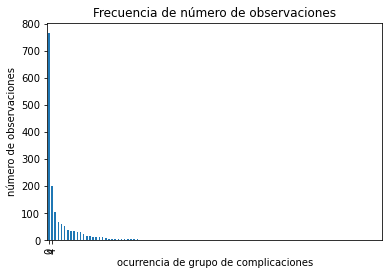

In [21]:
count_classes = pd.value_counts(mi_df['COMPLICATION_OUT'], sort = True)

count_classes.plot(kind = 'bar', #bar: gráfico de barras
                   rot=90)#0 = no rotación de las etiquetas del eje x
plt.xticks(range(2))
plt.title("Frecuencia de número de observaciones")
plt.xlabel("ocurrencia de grupo de complicaciones")
plt.ylabel("número de observaciones")

In [22]:
# from imblearn.combine import SMOTETomek

# y_train=pd.DataFrame(y_train,
#                      columns=["COMPLICATION_OUT"])


# os_us = SMOTETomek(sampling_strategy="all")

# X_t_st, y_t_st = os_us.fit_resample(X_train_std, y_train)
# #Datos de entrenamiento
# x_t_st= pd.DataFrame(X_t_st, columns=X_train.columns.tolist())
# y_t_st= pd.DataFrame(y_t_st, columns=["COMPLICATION_OUT"])

# X_train_smotetomek = pd.concat([x_t_st, y_t_st], axis=1)
# X_train_smotetomek.head()

In [23]:

# count_classes.plot(kind = 'bar', rot=0)
# plt.xticks(range(2))
# plt.title("Frecuencia de número de observaciones")
# plt.xlabel("ocurrencia de incidentes")
# plt.ylabel("número de observaciones")

---

In [24]:
mi_df[var_objetivo_lst+["COMPLICATION_OUT"]].drop_duplicates().to_csv('data/02_data_intermedia/COMPLICACION_DECOD.csv',index=False)

In [25]:
X_train.to_csv('data/02_data_intermedia/X_MI_entrenamiento_preprocesado.csv',index=False)
X_test.to_csv('data/02_data_intermedia/X_MI_pruebas_preprocesado.csv',index=False)

y_train.to_csv('data/02_data_intermedia/y_MI_entrenamiento_preprocesado.csv',index=False)
y_test.to_csv('data/02_data_intermedia/y_MI_pruebas_preprocesado.csv',index=False)

In [26]:
(mi_df.isnull().sum() / len(mi_df)*100)

SEX                 0.0
FIBR_PREDS          0.0
PREDS_TAH           0.0
JELUD_TAH           0.0
FIBR_JELUD          0.0
                   ... 
GEPAR_S_n           0.0
ASP_S_n             0.0
TIKL_S_n            0.0
TRENT_S_n           0.0
COMPLICATION_OUT    0.0
Length: 104, dtype: float64

In [27]:
count_classes

0       765
4       202
1       105
1024     68
32       59
       ... 
514       1
515       1
546       1
548       1
1664      1
Name: COMPLICATION_OUT, Length: 106, dtype: int64